In [25]:
library(clusterProfiler)
library(dplyr)
library(ggplot2)
library(reshape2)
library(tximport)
library(DESeq2)
library(pheatmap)
# library(RColorBrewer)
library(AnnotationDbi)
library(vsn)
library(DRIMSeq)
library(stageR)
library(ggrepel)
library(org.Mm.eg.db)
library(enrichplot)
library(ReactomePA)
library(DEXSeq)


Loading required package: BiocParallel

Loading required package: RColorBrewer



#  Load data with tximport

In [2]:
tx = c('CONTROL_REP1','CONTROL_REP2','KO_REP1','KO_REP2')
samps= as.data.frame(cbind(tx,c('CONTROL','CONTROL','KO','KO')))
colnames(samps)=c('sample_id','condition')
files <- file.path("/data/lemsaraa/bulk_wt1os/nf_outs/star_salmon/", samps$sample_id, "quant.sf")
names(files) <- samps$sample_id
head(files)

CONTROL_REP1 
"/data/lemsaraa/bulk_wt1os/nf_outs/star_salmon//CONTROL_REP1/quant.sf" 
                                                          CONTROL_REP2 
"/data/lemsaraa/bulk_wt1os/nf_outs/star_salmon//CONTROL_REP2/quant.sf" 
                                                               KO_REP1 
     "/data/lemsaraa/bulk_wt1os/nf_outs/star_salmon//KO_REP1/quant.sf" 
                                                               KO_REP2 
     "/data/lemsaraa/bulk_wt1os/nf_outs/star_salmon//KO_REP2/quant.sf"

In [3]:
# use scaledTPM as described in https://www.bioconductor.org/packages/release/workflows/vignettes/rnaseqDTU/inst/doc/rnaseqDTU.html

In [4]:
txi <- tximport(files, type="salmon", txOut=TRUE,
                countsFromAbundance="scaledTPM")
cts <- txi$counts
cts <- cts[rowSums(cts) > 0,]

reading in files with read_tsv

1 
2 
3 
4 




## Transcript-to-gene mapping


In [5]:
txdf=unique(read.table('nf_outs/star_salmon/salmon_tx2gene.tsv', sep='\t'))
colnames(txdf)= c('TXNAME','GENEID','GENENAME')
rownames(txdf)=txdf$TXNAME

In [6]:
# cts <- cts[txdf$TXNAME,]
txdf=txdf[rownames(cts),]
all(rownames(cts) == txdf$TXNAME)
counts <- data.frame(gene_id=txdf$GENEID,
                     feature_id=txdf$TXNAME,
                     cts)


[1] TRUE

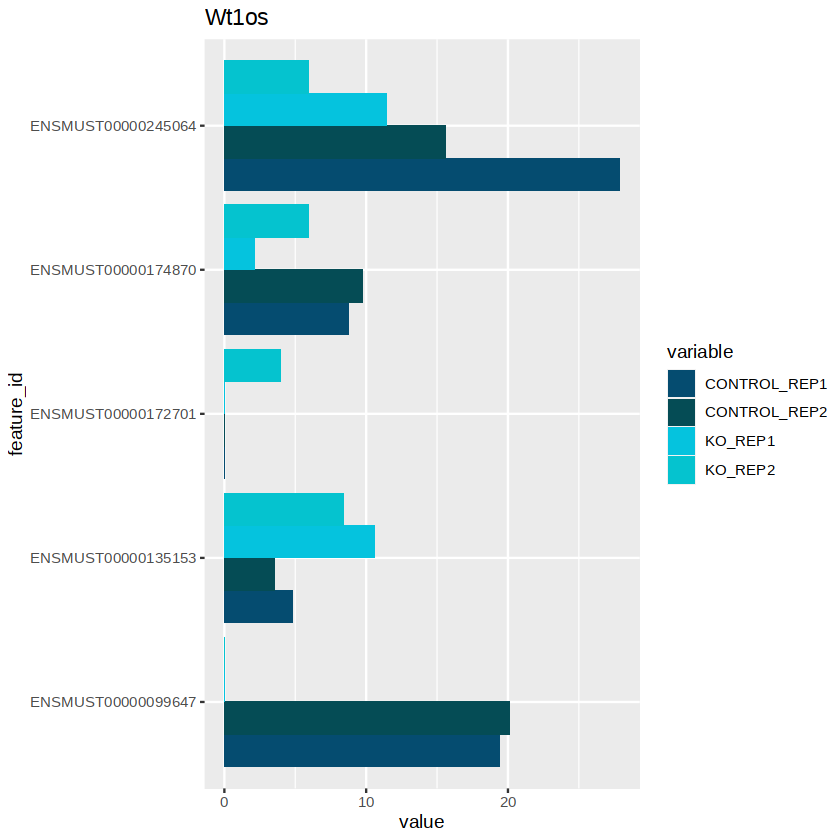

In [7]:
dat=counts[c('ENSMUST00000135153','ENSMUST00000172701','ENSMUST00000099647','ENSMUST00000174870','ENSMUST00000245064'),]
# dat$feature_id = rownames(dat)
dat = dat[which(dat$gene_id != 'NA'),]
dat = melt(dat, id=c('gene_id','feature_id'))
ggplot(dat,                                      # Grouped barplot using ggplot2
       aes(x = feature_id,
           y = value,
           fill =variable )) +
  geom_bar(stat = "identity",
           position = "dodge")+coord_flip()+scale_fill_manual(values = c("#054C70","#054C55","#05C3DE","#05C3cF")) + ggtitle('Wt1os')
#   facet_wrap(~gene_id, ncol=1)

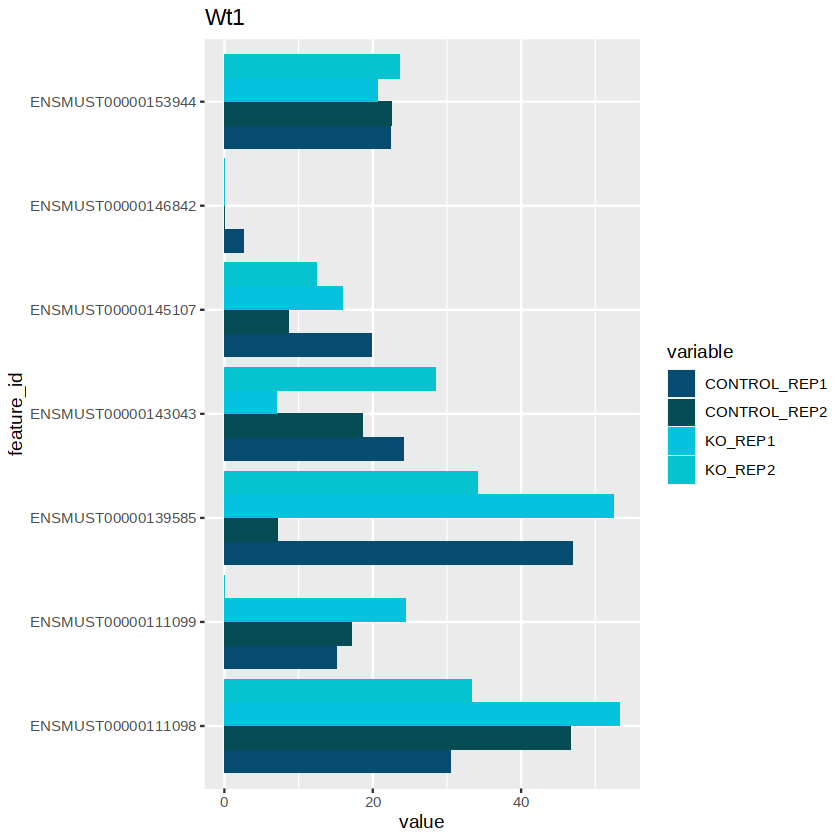

In [8]:
dat=counts[c(
 'ENSMUST00000143043','ENSMUST00000146842','ENSMUST00000133470','ENSMUST00000139585'
 ,'ENSMUST00000145107','ENSMUST00000111098','ENSMUST00000111099','ENSMUST00000153944'),]
# dat$feature_id = rownames(dat)
dat = dat[which(dat$gene_id != 'NA'),]
dat = melt(dat, id=c('gene_id','feature_id'))
ggplot(dat,                                      # Grouped barplot using ggplot2
       aes(x = feature_id,
           y = value,
           fill =variable )) +
  geom_bar(stat = "identity",
           position = "dodge")+coord_flip()+scale_fill_manual(values = c("#054C70","#054C55","#05C3DE","#05C3cF"))+ ggtitle('Wt1')
#   facet_wrap(~gene_id, ncol=1)

# DRIMSeq

In [9]:
# set min expresssion to 2 as we know that some transcripts from Wt1os have very low expression

In [10]:
d <- dmDSdata(counts=counts, samples=samps)
d
methods(class=class(d))
n <- 4
n.small <- 1
d <- dmFilter(d,
              min_samps_feature_expr=n.small, min_feature_expr=2,
              min_samps_gene_expr=n, min_gene_expr=2)
d

An object of class dmDSdata 
with 33602 genes and 4 samples
* data accessors: counts(), samples()

[1] [           counts      dmFilter    dmPrecision length      names      
[7] plotData    samples     show       
see '?methods' for accessing help and source code

An object of class dmDSdata 
with 13354 genes and 4 samples
* data accessors: counts(), samples()

In [11]:
design_full <- model.matrix(~condition, data=DRIMSeq::samples(d))
colnames(design_full)

[1] "(Intercept)" "conditionKO"

In [12]:
set.seed(1)
# system.time({
#   d <- dmPrecision(d, design=design_full)
#   d <- dmFit(d, design=design_full)
#   d <- dmTest(d, coef="conditionKO")
# })

In [13]:
d = readRDS('d.rds')
res <- DRIMSeq::results(d)
head(res)

,gene_id,lr,df,pvalue,adj_pvalue
,<chr>,<dbl>,<dbl>,<dbl>,<dbl>
1,ENSMUSG00000025900,0.05757087,1,0.81037730,1.0000000
2,ENSMUSG00000025902,7.33094994,5,0.19716751,0.9431285
3,ENSMUSG00000033845,0.35768726,5,0.99641535,1.0000000
4,ENSMUSG00000025903,5.40069284,7,0.61118763,1.0000000
5,ENSMUSG00000033813,0.43439075,1,0.50984230,1.0000000
6,ENSMUSG00000033793,17.34767814,7,0.01528673,0.2919353


In [14]:
res.txp <- DRIMSeq::results(d, level="feature")
head(res.txp)

,gene_id,feature_id,lr,df,pvalue,adj_pvalue
,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>
1,ENSMUSG00000025900,ENSMUST00000208660,0.05757087,1,0.8103773,1
2,ENSMUSG00000025900,ENSMUST00000027032,0.05757087,1,0.8103773,1
3,ENSMUSG00000025902,ENSMUST00000027035,0.04147833,1,0.8386174,1
4,ENSMUSG00000025902,ENSMUST00000195555,NA,1,NA,NA
5,ENSMUSG00000025902,ENSMUST00000192650,0.46862568,1,0.4936201,1
6,ENSMUSG00000025902,ENSMUST00000192505,-0.02018250,1,1.0000000,1


In [15]:
no.na <- function(x) ifelse(is.na(x), 1, x)
res$pvalue <- no.na(res$pvalue)
res.txp$pvalue <- no.na(res.txp$pvalue)

In [16]:
# plot top gene


,gene_id,lr,df,pvalue,adj_pvalue
,<chr>,<dbl>,<dbl>,<dbl>,<dbl>
220,ENSMUSG00000026005,14.15485,2,0.0008439451,0.04685863


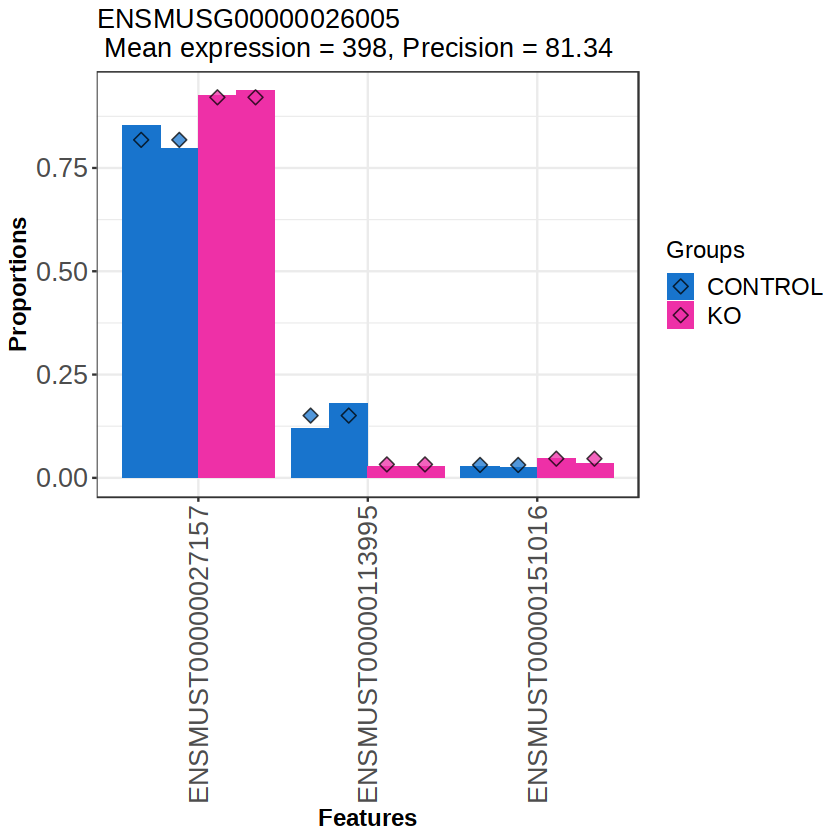

In [17]:
idx <- which(res$adj_pvalue < 0.05)[1]
res[idx,]
plotProportions(d, res$gene_id[idx], "condition", plot_main = T)


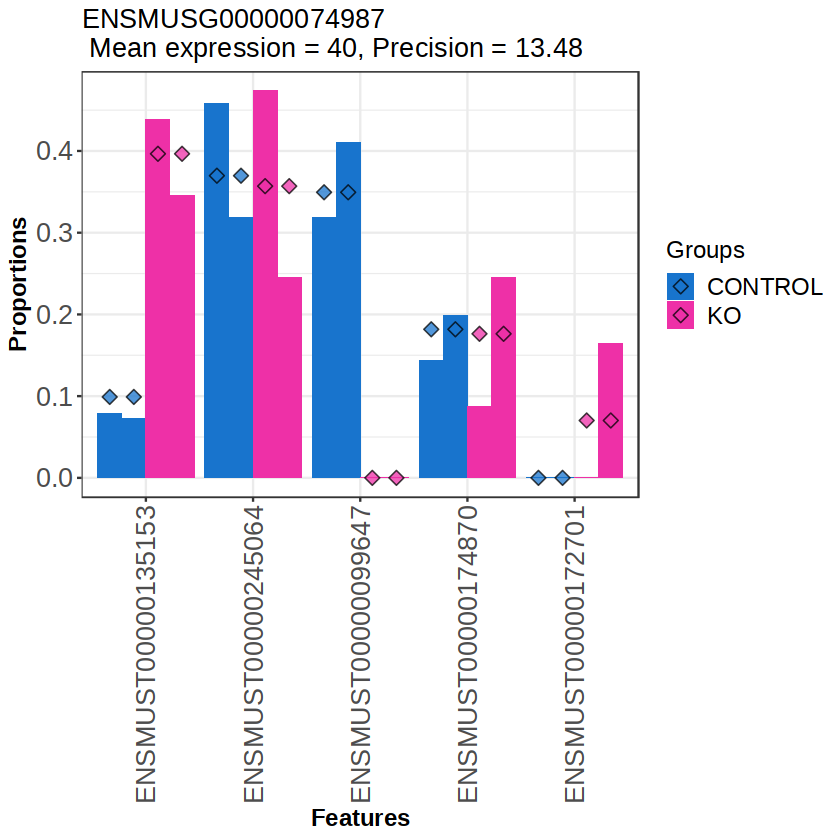

In [18]:
# plot DTU for Wt1os gene 
plotProportions(d, 'ENSMUSG00000074987', "condition")


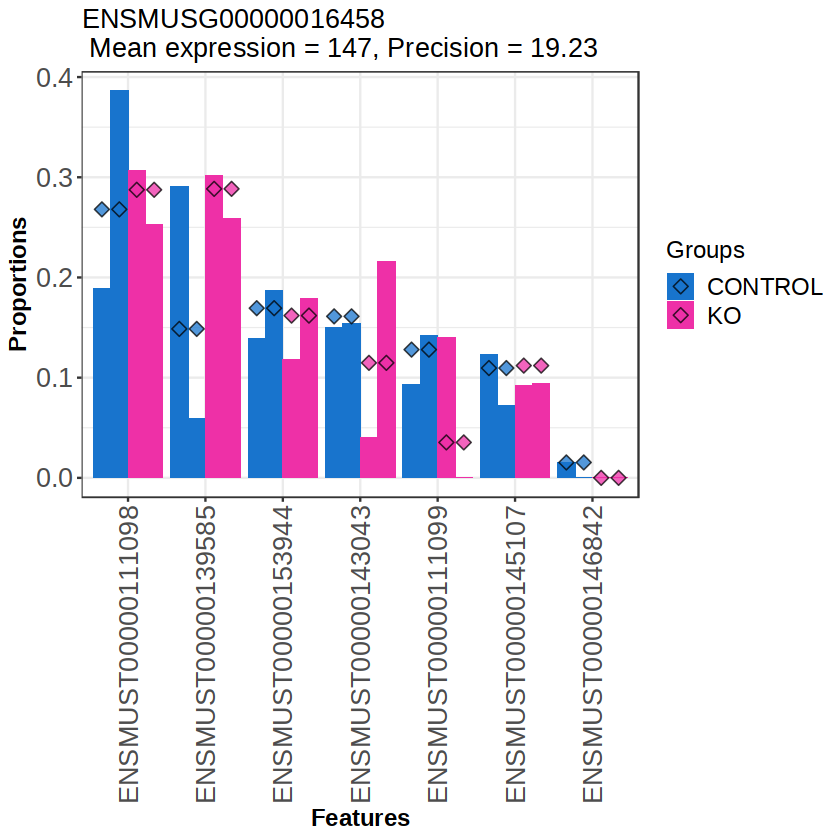

In [19]:
plotProportions(d, 'ENSMUSG00000016458', "condition")


In [20]:
pScreen <- res$pvalue
strp <- function(x) substr(x,1,20)
names(pScreen) <- strp(res$gene_id)

In [21]:
pConfirmation <- matrix(res.txp$pvalue, ncol=1)
rownames(pConfirmation) <- strp(res.txp$feature_id)

In [22]:
tx2gene <- res.txp[,c("feature_id", "gene_id")]
for (i in 1:2) tx2gene[,i] <- strp(tx2gene[,i])

In [23]:

stageRObj <- stageRTx(pScreen=pScreen, pConfirmation=pConfirmation,
                      pScreenAdjusted=FALSE, tx2gene=tx2gene)
stageRObj <- stageWiseAdjustment(stageRObj, method="dtu", alpha=0.1)
suppressWarnings({
  drim.padj <- getAdjustedPValues(stageRObj, order=FALSE,
                                  onlySignificantGenes=TRUE)
})
drim.padj[which(drim.padj$geneID == 'ENSMUSG00000074987'),]

The returned adjusted p-values are based on a stage-wise testing approach and are only valid for the provided target OFDR level of 10%. If a different target OFDR level is of interest,the entire adjustment should be re-run. 




,geneID,txID,gene,transcript
,<chr>,<chr>,<dbl>,<dbl>
1014,ENSMUSG00000074987,ENSMUST00000135153,0.02682711,1
1015,ENSMUSG00000074987,ENSMUST00000172701,0.02682711,1
1016,ENSMUSG00000074987,ENSMUST00000099647,0.02682711,1
1017,ENSMUSG00000074987,ENSMUST00000174870,0.02682711,1
1018,ENSMUSG00000074987,ENSMUST00000245064,0.02682711,1


In [90]:
write.csv(drim.padj, 'DTU_DEXSeq_stageR_adjP.csv', row.names=F)

In [ ]:
saveRDS(d,'d.rds')

In [ ]:
d = readRDS('d.rds')

# DEXSeq

In [26]:
sample.data <- DRIMSeq::samples(d)
count.data <- round(as.matrix(counts(d)[,-c(1:2)]))
dxd <- DEXSeqDataSet(countData=count.data,
                     sampleData=sample.data,
                     design=~sample + exon + condition:exon,
                     featureID=counts(d)$feature_id,
                     groupID=counts(d)$gene_id)

converting counts to integer mode

Warning message in DESeqDataSet(rse, design, ignoreRank = TRUE):
“some variables in design formula are characters, converting to factors”


In [27]:
system.time({
  dxd <- estimateSizeFactors(dxd)
  dxd <- estimateDispersions(dxd, quiet=TRUE)
  dxd <- testForDEU(dxd, reducedModel=~sample + exon)
  dxd = estimateExonFoldChanges(dxd, fitExpToVar="condition")
})

   user  system elapsed 
514.312 638.333 384.625 

In [28]:
dxr <- DEXSeqResults(dxd, independentFiltering=FALSE)
qval <- perGeneQValue(dxr)
# dxr.g <- data.frame(gene=names(qval),qval)

In [29]:
columns <- c("featureID","groupID","pvalue")
dxr <- as.data.frame(dxr[,columns])
head(dxr)

,featureID,groupID,pvalue
,<chr>,<chr>,<dbl>
ENSMUSG00000025900:ENSMUST00000208660,ENSMUST00000208660,ENSMUSG00000025900,0.6916947
ENSMUSG00000025900:ENSMUST00000027032,ENSMUST00000027032,ENSMUSG00000025900,0.7143828
ENSMUSG00000025902:ENSMUST00000027035,ENSMUST00000027035,ENSMUSG00000025902,0.6592945
ENSMUSG00000025902:ENSMUST00000195555,ENSMUST00000195555,ENSMUSG00000025902,0.4948522
ENSMUSG00000025902:ENSMUST00000192650,ENSMUST00000192650,ENSMUSG00000025902,0.6194010
ENSMUSG00000025902:ENSMUST00000192505,ENSMUST00000192505,ENSMUSG00000025902,0.9348009


In [30]:
strp <- function(x) substr(x,1,20)
pConfirmation <- matrix(dxr$pvalue,ncol=1)
dimnames(pConfirmation) <- list(strp(dxr$featureID),"transcript")
pScreen <- qval
names(pScreen) <- strp(names(pScreen))
tx2gene <- as.data.frame(dxr[,c("featureID", "groupID")])
for (i in 1:2) tx2gene[,i] <- strp(tx2gene[,i])

In [31]:
stageRObj <- stageRTx(pScreen=pScreen, pConfirmation=pConfirmation,
                      pScreenAdjusted=TRUE, tx2gene=tx2gene)
stageRObj <- stageWiseAdjustment(stageRObj, method="dtu", alpha=0.05)
suppressWarnings({
  dex.padj <- getAdjustedPValues(stageRObj, order=FALSE,
                                 onlySignificantGenes=TRUE)
})

The returned adjusted p-values are based on a stage-wise testing approach and are only valid for the provided target OFDR level of 5%. If a different target OFDR level is of interest,the entire adjustment should be re-run. 




In [32]:
 c('ENSMUSG00000074987','ENSMUSG00000016458') %in% dex.padj$geneID 


[1]  TRUE FALSE

In [33]:
dex.padj[which(dex.padj$geneID == 'ENSMUSG00000074987'),]

,geneID,txID,gene,transcript
,<chr>,<chr>,<dbl>,<dbl>
4499,ENSMUSG00000074987,ENSMUST00000135153,0.002194582,0.0400332696
4500,ENSMUSG00000074987,ENSMUST00000172701,0.002194582,1.0000000000
4501,ENSMUSG00000074987,ENSMUST00000099647,0.002194582,0.0006210665
4502,ENSMUSG00000074987,ENSMUST00000174870,0.002194582,1.0000000000
4503,ENSMUSG00000074987,ENSMUST00000245064,0.002194582,1.0000000000


In [35]:
dex.padj[which(dex.padj$gene <0.1), ]

,geneID,txID,gene,transcript
,<chr>,<chr>,<dbl>,<dbl>
1,ENSMUSG00000033793,ENSMUST00000192847,1.225225e-02,1.000000e+00
2,ENSMUSG00000033793,ENSMUST00000044369,1.225225e-02,1.000000e+00
3,ENSMUSG00000033793,ENSMUST00000194676,1.225225e-02,1.000000e+00
4,ENSMUSG00000033793,ENSMUST00000194301,1.225225e-02,1.000000e+00
5,ENSMUSG00000033793,ENSMUST00000194978,1.225225e-02,1.000000e+00
6,ENSMUSG00000033793,ENSMUST00000192029,1.225225e-02,1.000000e+00
7,ENSMUSG00000033793,ENSMUST00000192698,1.225225e-02,9.792206e-03
8,ENSMUSG00000033793,ENSMUST00000192142,1.225225e-02,1.000000e+00
9,ENSMUSG00000098234,ENSMUST00000247721,2.669806e-02,1.000000e+00


# DGE

In [36]:
txi.g <- tximport(files, type="salmon", tx2gene=txdf[,1:2])


reading in files with read_tsv

1 
2 
3 
4 


transcripts missing from tx2gene: 56107

summarizing abundance

summarizing counts

summarizing length



In [115]:
dds <- DESeqDataSetFromTximport(txi.g, samps, ~condition)


Warning message in DESeqDataSet(se, design = design, ignoreRank):
“some variables in design formula are characters, converting to factors”
using counts and average transcript lengths from tximport



In [116]:
melted=melt(assay(dds) )
colnames(melted)= c('Gene','Group','Value')

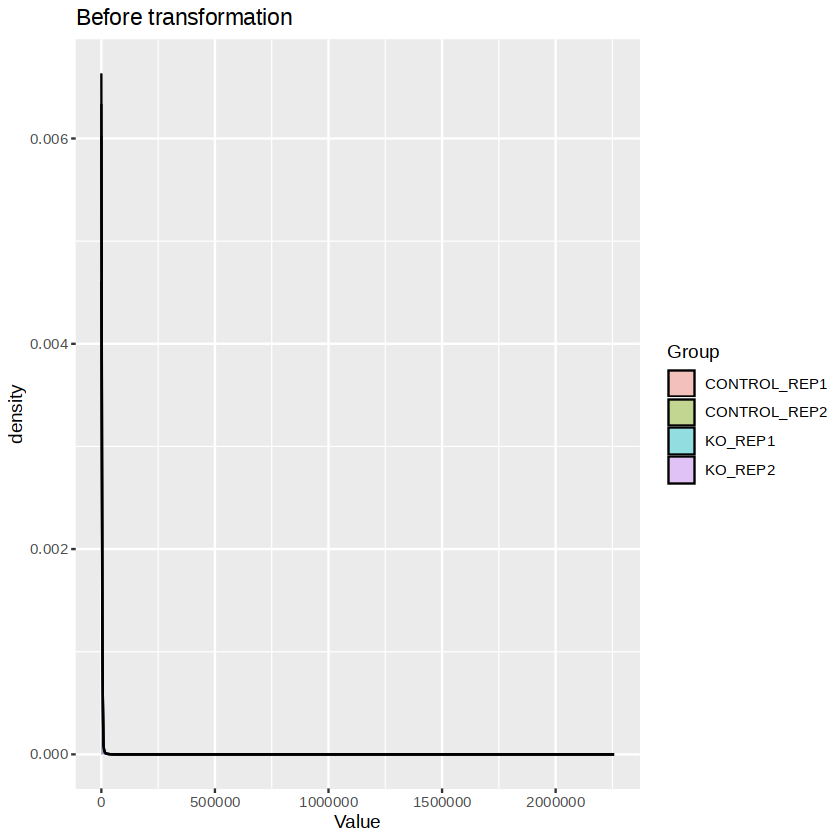

In [117]:
ggplot(data=melted, aes(x=Value, group=Group, fill= Group)) +
    geom_density(adjust=1.5, alpha=.4) + ggtitle('Before transformation')
#     theme_ipsum()

[1] 33602

[1] 17683

Warning message:
“Computation failed in `stat_binhex()`
Caused by error in `compute_group()`:
! The package "hexbin" is required for `stat_binhex()`”
using 'avgTxLength' from assays(dds), correcting for library size

Warning message:
“Computation failed in `stat_binhex()`
Caused by error in `compute_group()`:
! The package "hexbin" is required for `stat_binhex()`”


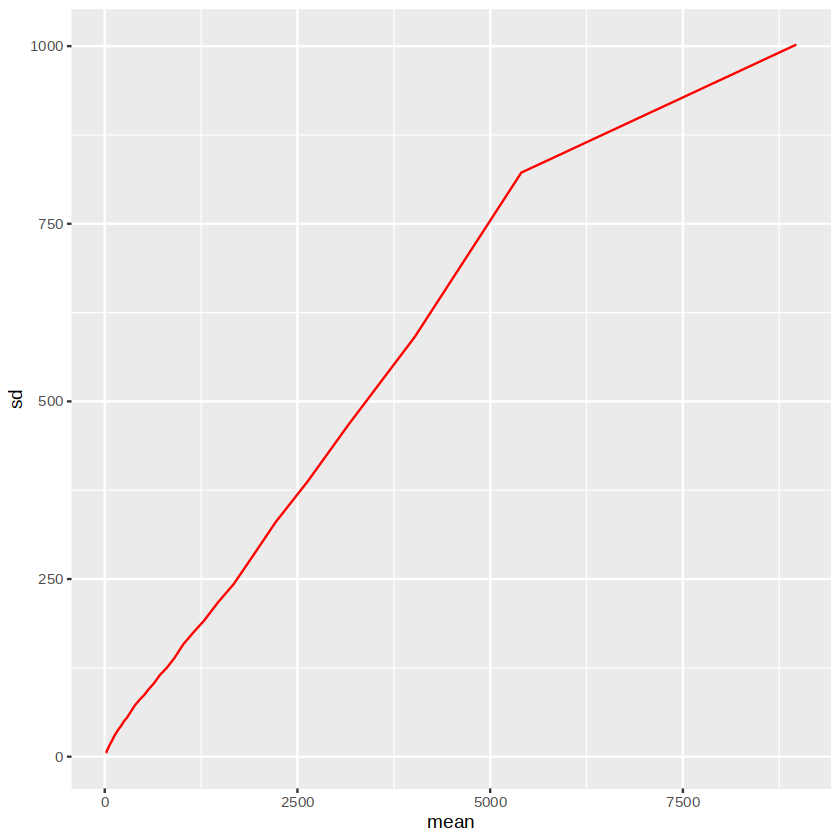

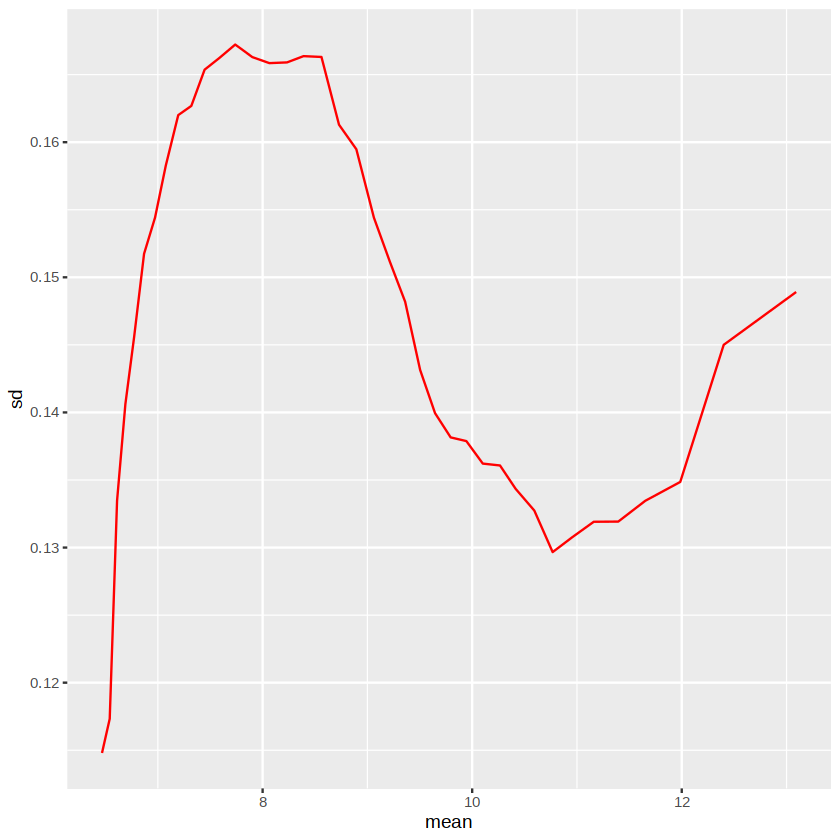

In [119]:
nrow(dds)
keep <- rowSums(counts(dds) >= 10) >= 4
dds <- dds[keep,]
nrow(dds)
#transformation
meanSdPlot(assay(dds), ranks = FALSE)

vsd <- vst(dds, blind = TRUE)
meanSdPlot(assay(vsd), ranks = FALSE)

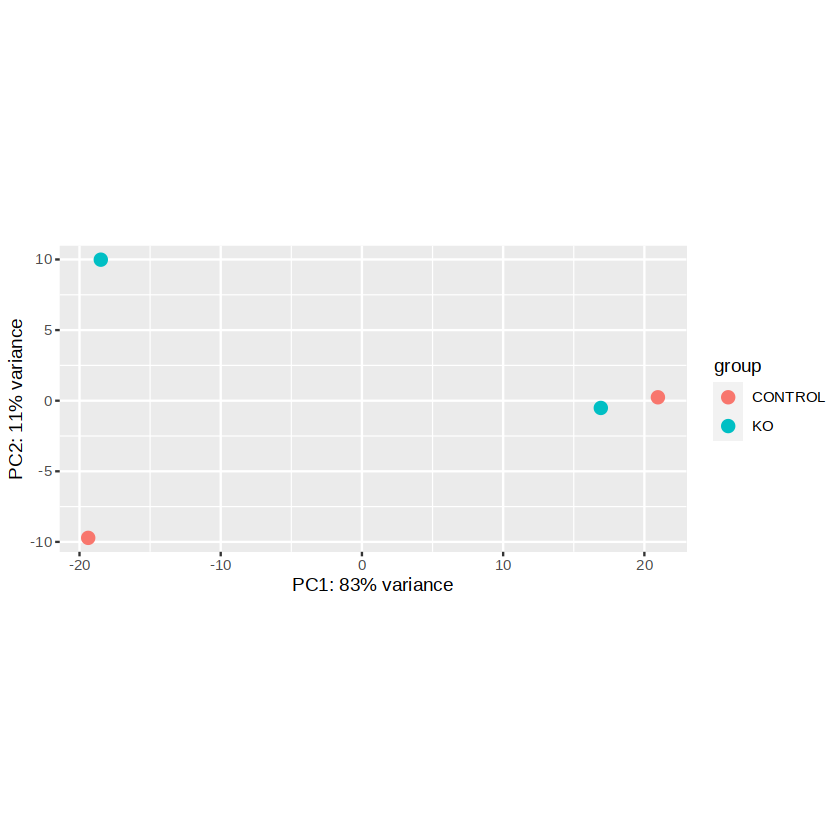

In [39]:
plotPCA(vsd, intgroup = c("condition"))

In [78]:
dds <- estimateSizeFactors(dds)
dds$condition= relevel(dds$condition, ref= 'CONTROL')

dds <- DESeq(dds)
dres <- DESeq2::results(dds)

using 'avgTxLength' from assays(dds), correcting for library size

using pre-existing normalization factors

estimating dispersions

found already estimated dispersions, replacing these

gene-wise dispersion estimates

mean-dispersion relationship

final dispersion estimates

fitting model and testing



In [79]:
summary(dres)
resSig <- subset(dres, padj < 0.1)
resSig


out of 21136 with nonzero total read count
adjusted p-value < 0.1
LFC > 0 (up)       : 11, 0.052%
LFC < 0 (down)     : 6, 0.028%
outliers [1]       : 0, 0%
low counts [2]     : 0, 0%
(mean count < 2)
[1] see 'cooksCutoff' argument of ?results
[2] see 'independentFiltering' argument of ?results



log2 fold change (MLE): condition KO vs CONTROL 
Wald test p-value: condition KO vs CONTROL 
DataFrame with 17 rows and 6 columns
                    baseMean log2FoldChange     lfcSE      stat      pvalue
                   <numeric>      <numeric> <numeric> <numeric>   <numeric>
ENSMUSG00000005089  416.6797        1.25984  0.278133   4.52963 5.90874e-06
ENSMUSG00000043346   15.0394        7.29042  1.836727   3.96924 7.21014e-05
ENSMUSG00000048572 4017.0850       -1.05620  0.225617  -4.68136 2.84976e-06
ENSMUSG00000062554   15.0548        7.30322  1.766876   4.13341 3.57424e-05
ENSMUSG00000078898  482.7227        1.16359  0.273995   4.24674 2.16899e-05
...                      ...            ...       ...       ...         ...
ENSMUSG00000112241   15.6715        7.35004  1.798635   4.08646 4.38012e-05
ENSMUSG00000119774   47.6199        8.96345  1.645697   5.44660 5.13427e-08
ENSMUSG00000119892 5119.2623       -1.13985  0.270237  -4.21795 2.46534e-05
ENSMUSG00002074955  176.4927      

In [80]:
# library("ashr")
# resultsNames(dds)
# res <- lfcShrink(dds, coef="condition_KO_vs_CONTROL", type="ashr")
# plotMA(res, ylim = c(-30, 20))

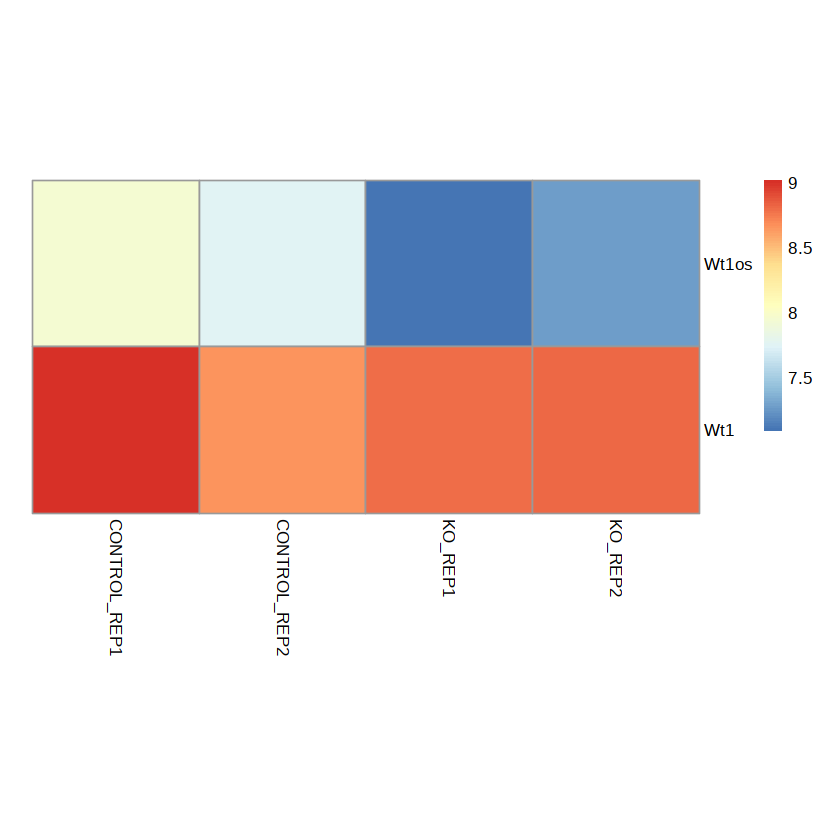

In [81]:
library("genefilter")
topVarGenes <- c('ENSMUSG00000074987','ENSMUSG00000016458')
mat  <- assay(vsd)[topVarGenes, ]
# mat  <- mat - rowMeans(mat)
rownames(mat)=c('Wt1os','Wt1')
anno <- as.data.frame(colData(vsd)[, c("condition")])
pheatmap(mat,cluster_rows = F, cluster_cols = F,cellwidth = 100,cellheight = 100)

In [82]:
gene_id=unique(read.table('nf_outs/star_salmon/salmon_tx2gene.tsv', sep='\t',row.names = 1))
colnames(gene_id)=c('symbol','name')
resSig$symbol=rownames(resSig)
resSig=merge(as.data.frame(resSig), gene_id, by= 'symbol')

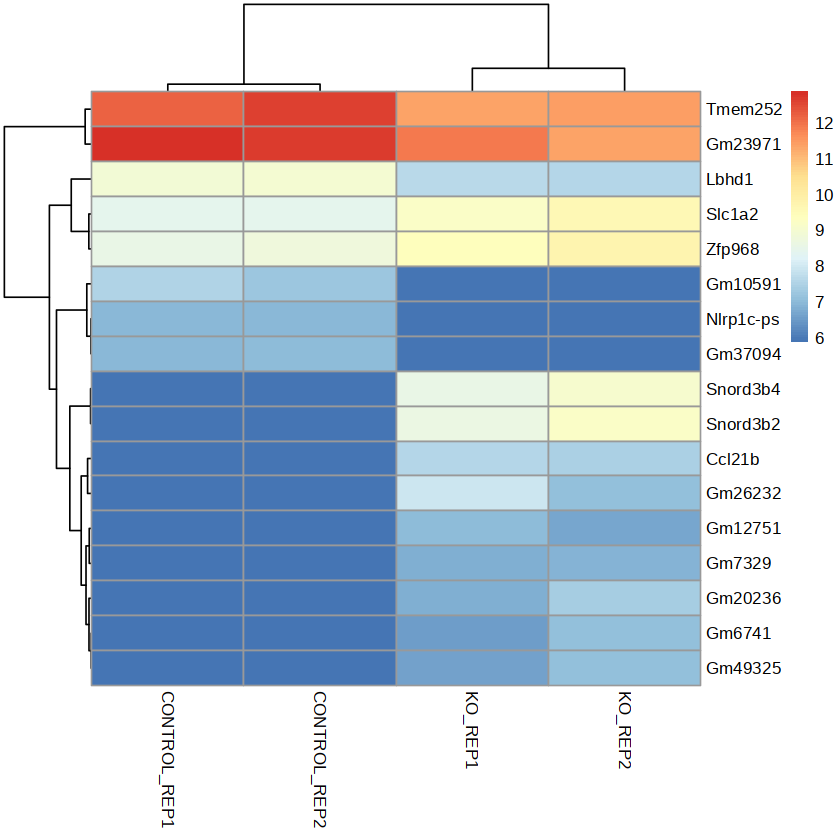

In [83]:
topVarGenes <- resSig$symbol
mat  <- assay(vsd)[topVarGenes, ]
# mat  <- mat - rowMeans(mat)
rownames(mat)=as.character(resSig$name)
anno <- as.data.frame(colData(vsd)[, c("condition")])
pheatmap(mat)

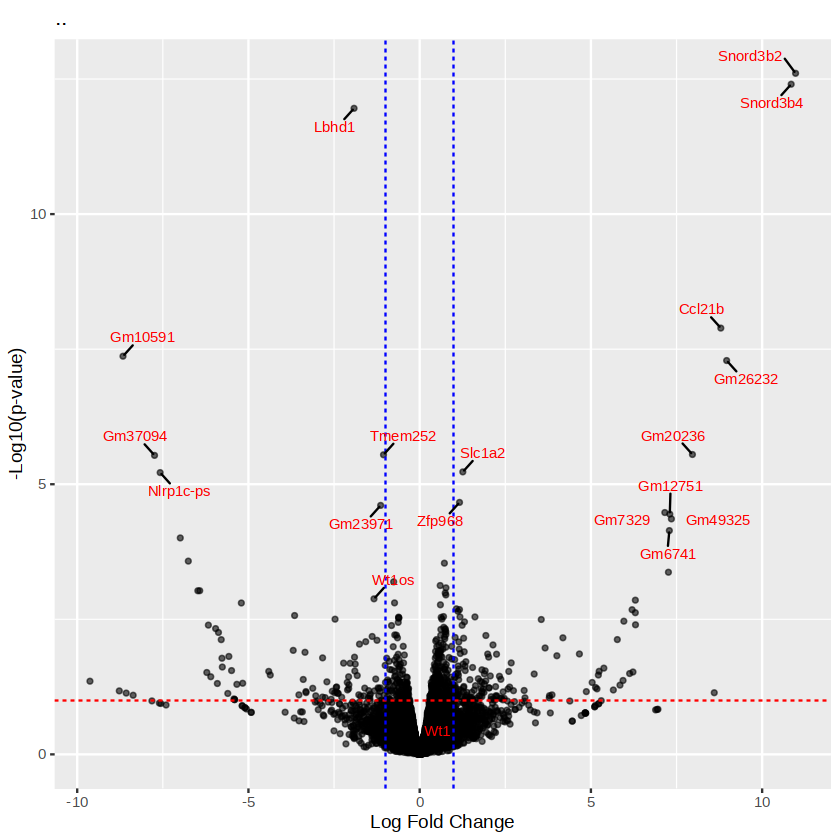

In [84]:
topg= c(topVarGenes,c('ENSMUSG00000074987','ENSMUSG00000016458'))
resu=as.data.frame(dres)
resu$symbol=rownames(resu)
resu=merge(resu, gene_id, by= 'symbol')
top_proteins <- resu[which( resu$symbol %in% topg),]

p=ggplot(resu, aes(x=log2FoldChange, y=-log10(pvalue))) + 
  geom_point(color="black", alpha=0.6, size=1) +
  ggtitle('..') +   
  scale_x_continuous("Log Fold Change") +
  scale_y_continuous("-Log10(p-value)") +
  geom_hline(yintercept=-log10(0.1), linetype="dashed", color="red") +
  geom_vline(xintercept=c(-1,1), linetype="dashed", color="blue") +
  geom_text_repel(data=top_proteins, aes(x=log2FoldChange, y=-log10(pvalue), label=top_proteins$name), size=3,
                     segment.color = 'black',
    colour = "red", box.padding = 0.5 # assign it here
)    
p


In [88]:
write.csv(resu, 'DGE_DESeq2.csv', row.names=F)

In [47]:
gene.df <- bitr(resu$symbol, fromType = "ENSEMBL",
        toType = c("ENTREZID", "SYMBOL"),
        OrgDb = org.Mm.eg.db)
resu=merge(resu, gene.df, by.x = 'symbol',by.y='ENSEMBL')

'select()' returned 1:many mapping between keys and columns

Warning message in bitr(resu$symbol, fromType = "ENSEMBL", toType = c("ENTREZID", :
“22.39% of input gene IDs are fail to map...”


In [48]:
# theme_s=theme(plot.margin = margin(0.5,0.5,0.5,0.5, "cm"),
#               plot.caption = element_text(color = "red", face = "bold"),
#              plot.title = element_text(color = "black", size = 24, face = "bold"),
#   plot.subtitle = element_text(color = "blue"),
             
#              legend.text = element_text(size=20),text =element_text(size=20),axis.title = element_text(size = 16)
#          , title =element_text(size=20) 
#              )

# inter= function(o,enrich){

# cont=FALSE
    
# for (oo in c('CC','BP','MF')){
# deg=resu
# deg1 <- deg[deg$pvalue<0.1 & abs(deg$log2FoldChange)>1,]
    
# # differentially expressed genes ids
# degs <- deg1$ENTREZID
# # all gene ids
# bgs <- deg$ENTREZID
# mydf <- data.frame(Entrez=degs, FC=deg1$log2FoldChange)
# mydf$group <- "upregulated"
# mydf$group[mydf$FC < 0] <- "downregulated"
# if (o=='MKEGG'){

# formula_res_ <- compareCluster(Entrez~group, data=mydf, fun="enrichMKEGG",organism='mmu',universe=bgs)
# }else{
# formula_res_ <- compareCluster(Entrez~group, data=mydf, fun=enrich,keyType ="ENTREZID",universe=bgs,OrgDb=org.Mm.eg.db,ont=oo,
#                     readable=TRUE)
#     }
# if (cont && (class(formula_res_) =='compareClusterResult')){
# interMat= as.data.frame(formula_res_@compareClusterResult) 
# interMat$name= oo
# formula_res = rbind(formula_res,interMat)

#     }else{
#     if ( class(formula_res_) == 'compareClusterResult'){formula_res=as.data.frame(formula_res_@compareClusterResult)
#                                                         formula_res$name=oo
#                                                        cont= TRUE}}

#   }
#    # select top 10 go terms 
# col=colnames(formula_res)[grep("p.adjust", colnames(formula_res)) ]
# selected_rows <- sapply(col, function(x) formula_res %>% group_by(name,group) %>%  top_n(n=-10
#                            , wt=!!sym(x)) %>% ungroup() %>% dplyr::select(ID))
# selected_rows=unlist(selected_rows)
# sel_formula_res = formula_res[formula_res$ID %in% selected_rows,]     
# sel_formula_res= sel_formula_res[,c('group','name','Description','GeneRatio','p.adjust')]
# sel_formula_res$GeneRatio=sapply(sel_formula_res$GeneRatio, function(x) eval(parse(text = x)))
# sel_formula_res$Description= factor(sel_formula_res$Description, levels=unique(sel_formula_res$Description))
 
# # Create a dot plot
# p4 = ggplot(sel_formula_res, aes(x = name, y = Description, color = p.adjust, size=GeneRatio)) +
#   geom_point(aes(shape=group)) +
#       labs(x = "Contrast", y = "", title = paste0(o," Ontology")) +
# theme(axis.text.x = element_text(angle = 90, vjust = 0.5, hjust=1))+theme_s
# return(p4)   
# }

In [49]:
 

# #CC
# p4=inter('CC','enrichGO')
# p7=inter('MKEGG','enrichMKEGG')

#BP


In [50]:
# pdf(file = paste0('figures.pdf'),
#     # The directory you want to save the file in
#     width = 14, # The width of the plot in inches
#     height = 18) # The height of the plot in inches

# p4
# p7

# dev.off()

In [51]:
theme_s=theme(plot.margin = margin(0.5,0.5,0.5,0.5, "cm"),
              plot.caption = element_text(color = "red", face = "bold"),
             plot.title = element_text(color = "black", size = 24, face = "bold"),
  plot.subtitle = element_text(color = "blue"),
             
             legend.text = element_text(size=20),text =element_text(size=20),axis.title = element_text(size = 16)
         , title =element_text(size=20) 
             )

plots <- function(ek, num=10) {
if (class(ek) %in% c('enrichResult','gseaResult')){

tryCatch(expr={ek=simplify(ek)},
         error = function(e) {
    print('ok tryCatch....')  })
tryCatch({
p1 <- barplot(ek,showCategory=num)+theme_s
p2 <- dotplot(ek,showCategory=num)+theme_s
sim_mat <- pairwise_termsim(ek)
p3=emapplot(sim_mat)+theme_s
bg <- deg$log2FoldChange
names(bg) <- as.character(deg$ENTREZID)

p4=cnetplot(ek,foldChange=bg)+theme_s
p5=heatplot(ek,foldChange=bg)+coord_flip()+theme_s
    
pdf(file = paste0(name,ek@ontology,'.pdf'),
    # The directory you want to save the file in
    width = 7, # The width of the plot in inches
    height = 7) # The height of the plot in inches

print(p1)
print(p2)
print(p3)
print(p4)    
dev.off()

pdf(file = paste0(name,ek@ontology,'heatmap','.pdf'),
    # The directory you want to save the file in
    width = 10, # The width of the plot in inches
    height = 10) # The height of the plot in inches

print(p5)    
dev.off()
},error = function(e) {
    print('ok')  })
         
}
}

dotplots <- function(ek, num=10) {
    if (class(ek) %in% c('enrichResult','compareClusterResult')){
    p=dotplot(ek,showCategory=num)+theme_s
    }else{
    p=NULL
    }
        return(p)
    }

In [52]:
stageRObj <- stageWiseAdjustment(stageRObj, method="dtu", alpha=0.05)
suppressWarnings({
  dex.padj <- getAdjustedPValues(stageRObj, order=FALSE,
                                 onlySignificantGenes=TRUE)
})
gene.df <- bitr(counts(d)$gene_id, fromType = "ENSEMBL",
        toType = c("ENTREZID", "SYMBOL"),
        OrgDb = org.Mm.eg.db)
resu_dtu=merge(counts(d), gene.df, by.x = 'gene_id',by.y='ENSEMBL')                 
resu_dtu= unique(resu_dtu[,c('gene_id','ENTREZID')])                
dex.padj_gene= merge(dex.padj, resu_dtu, by.x = 'geneID',by.y='gene_id') 
length(unique(dex.padj_gene$geneID))
 name='KOvsCTRL_DTU'
# differentially expressed genes ids
degs <- unique(dex.padj_gene$ENTREZID )
# all gene ids
bgs <- unique(resu_dtu$ENTREZID)

print('start')
ego_cc <- enrichGO(gene=degs,keyType ="ENTREZID",universe=bgs,OrgDb=org.Mm.eg.db,ont="CC",
                    readable=TRUE)
ego_bp <- enrichGO(gene=degs ,keyType ="ENTREZID",universe=bgs,OrgDb=org.Mm.eg.db,ont="BP",
                    readable=TRUE)
ego_mf <- enrichGO(gene=degs,keyType ="ENTREZID",universe=bgs,OrgDb=org.Mm.eg.db,ont="MF",
                    readable=TRUE)
ek <- enrichMKEGG(gene=degs,organism='mmu', universe =bgs )
plots(ego_cc)
plots(ego_bp)
plots(ego_mf)
plots(ek)
ek <- enrichKEGG(gene=degs,organism='mmu', universe =bgs )
plots(ek)

print('comparison')
mydf <- data.frame(Entrez=deg1$ENTREZID, FC=deg1$log2FoldChange)
mydf$group <- "upregulated"
mydf$group[mydf$FC < 0] <- "downregulated"

formula_res <- compareCluster(Entrez~group, data=mydf, fun="enrichGO",keyType ="ENTREZID",universe=bgs,OrgDb=org.Mm.eg.db,ont="CC",
                    readable=TRUE)
p1= dotplots(formula_res)

formula_res <- compareCluster(Entrez~group, data=mydf, fun="enrichGO",keyType ="ENTREZID",universe=bgs,OrgDb=org.Mm.eg.db,ont="BP",
                    readable=TRUE)
p2= dotplots(formula_res)

formula_res <- compareCluster(Entrez~group, data=mydf, fun="enrichGO",keyType ="ENTREZID",universe=bgs,OrgDb=org.Mm.eg.db,ont="MF",
                    readable=TRUE)
p3 =dotplots(formula_res)

    
formula_res <- compareCluster(Entrez~group, data=mydf, fun="enrichMKEGG",organism='mmu',universe=bgs)
p4=dotplots(formula_res)
formula_res <- compareCluster(Entrez~group, data=mydf, fun="enrichKEGG",organism='mmu',universe=bgs)
p5=dotplots(formula_res)
pdf(file = paste0(name,'_compareclusters','.pdf'),
    # The directory you want to save the file in
    width = 7, # The width of the plot in inches
    height = 7) # The height of the plot in inches

print(p1)
print(p2)
print(p3)
print(p4)
print(p5)
dev.off()


The returned adjusted p-values are based on a stage-wise testing approach and are only valid for the provided target OFDR level of 5%. If a different target OFDR level is of interest,the entire adjustment should be re-run. 


'select()' returned 1:many mapping between keys and columns

Warning message in bitr(counts(d)$gene_id, fromType = "ENSEMBL", toType = c("ENTREZID", :
“4.56% of input gene IDs are fail to map...”


[1] 1059

[1] "start"


Reading KEGG annotation online: "https://rest.kegg.jp/link/mmu/module"...

Reading KEGG annotation online: "https://rest.kegg.jp/list/module"...



[1] "ok"
[1] "ok"
[1] "ok"
[1] "ok tryCatch...."
[1] "ok"


Reading KEGG annotation online: "https://rest.kegg.jp/link/mmu/pathway"...

Reading KEGG annotation online: "https://rest.kegg.jp/list/pathway/mmu"...



[1] "ok tryCatch...."
[1] "ok"
[1] "comparison"


ERROR: Error in data.frame(Entrez = deg1$ENTREZID, FC = deg1$log2FoldChange): object 'deg1' not found


In [ ]:

 name='KOvsCTRL'
 deg=resu
 deg1 <- deg[ deg$pvalue <0.05 & abs(deg$log2FoldChange)>1,]
    
# differentially expressed genes ids
degs <- deg1$ENTREZID
# all gene ids
bgs <- deg$ENTREZID

print('start')
ego_cc <- enrichGO(gene=degs,keyType ="ENTREZID",universe=bgs,OrgDb=org.Mm.eg.db,ont="CC",
                    readable=TRUE)
ego_bp <- enrichGO(gene=degs ,keyType ="ENTREZID",universe=bgs,OrgDb=org.Mm.eg.db,ont="BP",
                    readable=TRUE)
ego_mf <- enrichGO(gene=degs,keyType ="ENTREZID",universe=bgs,OrgDb=org.Mm.eg.db,ont="MF",
                    readable=TRUE)
ek <- enrichMKEGG(gene=degs,organism='mmu', universe =bgs )
plots(ego_cc)
plots(ego_bp)
plots(ego_mf)
plots(ek)
ek <- enrichKEGG(gene=degs,organism='mmu', universe =bgs )
plots(ek)

print('comparison')
mydf <- data.frame(Entrez=deg1$ENTREZID, FC=deg1$log2FoldChange)
mydf$group <- "upregulated"
mydf$group[mydf$FC < 0] <- "downregulated"

formula_res <- compareCluster(Entrez~group, data=mydf, fun="enrichGO",keyType ="ENTREZID",universe=bgs,OrgDb=org.Mm.eg.db,ont="CC",
                    readable=TRUE)
p1= dotplots(formula_res)

formula_res <- compareCluster(Entrez~group, data=mydf, fun="enrichGO",keyType ="ENTREZID",universe=bgs,OrgDb=org.Mm.eg.db,ont="BP",
                    readable=TRUE)
p2= dotplots(formula_res)

formula_res <- compareCluster(Entrez~group, data=mydf, fun="enrichGO",keyType ="ENTREZID",universe=bgs,OrgDb=org.Mm.eg.db,ont="MF",
                    readable=TRUE)
p3 =dotplots(formula_res)

    
formula_res <- compareCluster(Entrez~group, data=mydf, fun="enrichMKEGG",organism='mmu',universe=bgs)
p4=dotplots(formula_res)
formula_res <- compareCluster(Entrez~group, data=mydf, fun="enrichKEGG",organism='mmu',universe=bgs)
p5=dotplots(formula_res)
pdf(file = paste0(name,'_compareclusters','.pdf'),
    # The directory you want to save the file in
    width = 7, # The width of the plot in inches
    height = 7) # The height of the plot in inches

print(p1)
print(p2)
print(p3)
print(p4)
print(p5)
dev.off()


In [ ]:

 name='KOvsCTRL_reactome'
 deg=resu


    

    
deg1 <- deg$log2FoldChange
deg1 <- deg1[!is.na(deg1)]
names(deg1) <- deg$ENTREZID
degs1 = sort(deg1, decreasing = TRUE)
    
deg1 <- deg[ deg$pvalue <0.05 & abs(deg$log2FoldChange)>1,]


ek <- enrichPathway(gene=deg1$ENTREZID,organism='mouse',universe = deg$ENTREZID)
    

    
plots(ek)
    
print('comparison')
mydf <- data.frame(Entrez=deg1$ENTREZID, FC=deg1$log2FoldChange)
mydf$group <- "upregulated"
mydf$group[mydf$FC < 0] <- "downregulated"

formula_res <- compareCluster(Entrez~group, data=mydf, fun="enrichPathway",organism='mouse',universe = deg$ENTREZID)
p2=dotplots(formula_res)

pdf(file = paste0(name,'_compareclusters','.pdf'),
    # The directory you want to save the file in
    width = 7, # The width of the plot in inches
    height = 7) # The height of the plot in inches

print(p2)
dev.off()


# GSEA

In [ ]:
plots <- function(ek, num=10) {
if (class(ek) %in% c('enrichResult','gseaResult')){

tryCatch(expr={ek=simplify(ek)},
         error = function(e) {
    print('ok')  })
tryCatch(expr={
p2 <- dotplot(ek,x="NES",showCategory=num,orderBy = "NES")+theme_s
sim_mat <- pairwise_termsim(ek)
p3=emapplot(sim_mat,orderBy = "NES", color = "NES")+theme_s
bg <- deg$log2FoldChange
names(bg) <- as.character(deg$name)

p4=cnetplot(ek,foldChange=bg)+theme_s
p5=heatplot(ek,foldChange=bg)+coord_flip()+theme_s
    
pdf(file = paste0(name,ek@setType,'.pdf'),
    # The directory you want to save the file in
    width = 7, # The width of the plot in inches
    height = 7) # The height of the plot in inches

print(p2)
print(p3)
print(p4)    
dev.off()

pdf(file = paste0(name,ek@setType,'heatmap','.pdf'),
    # The directory you want to save the file in
    width = 10, # The width of the plot in inches
    height = 10) # The height of the plot in inches

print(p5)    
dev.off()
},         error = function(e) {
    print('ok tryCatch...')  }
         )
         
}}


In [ ]:
# name='GSEA_KOvsCTRL'

# deg=resu
# deg1 <- deg$log2FoldChange
# deg1 <- deg1[!is.na(deg1)]
# names(deg1) <- deg$ENTREZID
# degs1 = sort(deg1, decreasing = TRUE)
# res_inter=list()
# print('start')
# ego_cc <- gseGO(geneList=degs1,pvalueCutoff=0.05,keyType ="ENTREZID",OrgDb=org.Mm.eg.db,ont="CC")
# res_inter['ego_cc']= ego_cc                    
# ego_bp <- gseGO(geneList=degs1,pvalueCutoff=0.05 ,keyType ="ENTREZID",OrgDb=org.Mm.eg.db,ont="BP")
# res_inter['ego_bp']=ego_bp                                        
# ego_mf <- gseGO(geneList=degs1,pvalueCutoff=0.05,keyType ="ENTREZID",OrgDb=org.Mm.eg.db,ont="MF")
# res_inter['ego_mf']=ego_mf                                       
# ek <- gseMKEGG(geneList=degs1,pvalueCutoff=0.05,organism='mmu')

# res_inter['ek']=ek 
# ek2 <- gseKEGG(geneList=degs1,pvalueCutoff=0.05,organism='mmu')
# res_inter['ek']=ek2 

plots(ego_cc)
plots(ego_bp)
plots(ego_mf)
plots(ek)
plots(ek2)
